# Error Mitigation: Zero Noise Extrapolation (ZNE) for indirect-control system
---

_This notebook contains experimental results for Zero Noise Extrapolation (ZNE) in an indirect-control system._

Zero-Noise Extrapolation (ZNE) is one of the most widely used techniques in quantum error mitigation to estimate the expectation value of an observable under noise-free conditions. In ZNE, noise is intentionally introduced into the quantum circuit, and the expectation value of the target observable is measured at different noise levels. Once sufficient data is collected, we extrapolate this data to the zero-noise limit.

There are several strategies for zero-noise extrapolation, with the Richardson extrapolation technique being perhaps the most common. Here, we adapted the multivariate framework of Richardson extrapolation as discussed in the paper [_"Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo and Andrea Mari (arXiv:2402.04000, 2024)_](https://arxiv.org/abs/2402.04000).

### A. The code for multivariate Richardson extrapolation

In [1]:
"""
We have used the multivariate framework for Richardson extrapolation as discussed in the paper "Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo and Andrea Mari (arXiv:2402.04000, 2024).

Parts of the following code are adapted from their notebook, which can be found at the following GitHub repository: https://github.com/unitaryfund/research/blob/main/lre/layerwise_richardson_extrapolation.ipynb.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
import itertools
 

class ZeroNoiseExtrapolation:
    def __init__(self, dataPoints: list[tuple[float]], degree: int):
        """
        Initialize with a list of data points, each represented as a tuple of floats.
        """
        self.dataPoints = dataPoints
        self.degree = degree

        self.NoiseData = [tuple(point[:3]) for point in self.dataPoints]
        self.ExpectationVals = [point[-1] for point in dataPoints]

    def getRichardsonZNE(self):

        RichardsonZNEval = 0

        sampleMatrix = self.sample_matrix(sample_points = self.NoiseData, degree = self.degree) # type: ignore
        detA = np.linalg.det(sampleMatrix)

        matrices = self.generate_modified_matrices(sampleMatrix) # type: ignore

        for E, matrix in zip(self.ExpectationVals, matrices):
            RichardsonZNEval += E * (np.linalg.det(matrix)/detA)
        
        return RichardsonZNEval
     
    @staticmethod
    def get_monomials(n: int, d: int) -> list[str]:
        """
        Compute monomials of degree `d` in graded lexicographical order.
        """
        variables = [f"λ_{i}" for i in range(1, n + 1)]
        
        monomials = []
        for degree in range(d, -1, -1):
            # Generate combinations for the current degree
            combos = list(itertools.combinations_with_replacement(variables, degree))
            
            # Sort combinations lexicographically
            combos.sort()
            
            # Construct monomials from sorted combinations
            for combo in combos:
                monomial_parts = []
                counts = Counter(combo)
                # Ensure variables are processed in lexicographical order
                for var in sorted(counts.keys()):
                    count = counts[var]
                    if count > 1:
                        monomial_parts.append(f"{var}**{count}")
                    else:
                        monomial_parts.append(var)
                monomial = "*".join(monomial_parts)
                # Handle the case where degree is 0
                if not monomial:
                    monomial = "1"
                monomials.append(monomial)
        # "1" should be the first monomial. Note that order d > c > b > a means vector of monomials = [a, b, c, d].            
        return monomials[::-1]

    @staticmethod
    def sample_matrix(sample_points: list[int], degree: int) -> np.ndarray:
        """Construct a matrix from monomials evaluated at sample points."""
        n = len(sample_points[0])  # type: ignore # Number of variables based on the first sample point
        monomials = ZeroNoiseExtrapolation.get_monomials(n, degree) # type: ignore
        matrix = np.zeros((len(sample_points), len(monomials)))

        for i, point in enumerate(sample_points):
            for j, monomial in enumerate(monomials):
                var_mapping = {f"λ_{k+1}": point[k] for k in range(n)} # type: ignore
                matrix[i, j] = eval(monomial, {}, var_mapping)
        return matrix

    @staticmethod
    def generate_modified_matrices(matrix):
        """
        It generates the Mi(0) matreces for i = 1 to length of sample matrix.
        See this papaer for the detail mathematical formalism: 
        "Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo, Andrea Mari, https://arxiv.org/abs/2402.04000
        """
        n = len(matrix)  # Size of the square matrix
        identity_row = [1] + [0] * (n - 1)  # Row to replace with

        modified_matrices = []
        determinants = []
        for i in range(n):
            # Create a copy of the original matrix
            modified_matrix = np.copy(matrix)
            # Replace the i-th row with the identity_row
            modified_matrix[i] = identity_row
            modified_matrices.append(modified_matrix)
            # Calculate the determinant of the modified matrix
            determinant = np.linalg.det(modified_matrix)
            determinants.append(determinant)
        
        return modified_matrices    
    

In [7]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 15
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 12

### B. Experimental result

In our noisy indirect circuit, the noise level is determined by a vector parameter of length 3, which we refer to as _the noise factor_ (specified in the config file as `circuit.noise.factor`). This parameter dictates the number of redundant identities to be used in the circuit.

Based on the values of this vector parameter, we have defined the corresponding noise levels as $n_R, n_T$, and $n_Y$, which correspond to the noise levels due to rotational gates, the time evolution gate, and the Y gate, respectively. Therefore, we have three independent variables and one dependent variable (i.e., the expectation value).

#### 5-qubit system

For a 5-qubit system, Indirect-VQE yields satisfactory results with a depth of 10 layers in a noise-free circuit. Consequently, for the noisy circuit, we have selected the same circuit depth.

The noise probabilities for all single-qubit and multi-qubit gates are chosen to be 0.0001 in noisy circuit (`circuit.noise.value : [0.0001, 0.0001, 0.0001, 0.0001]`).

First, we ran the Indirect-VQE with noisy circuit, but without any redundent identities (`circuit.noise.factor: [0, 0, 0`]) and obtain the optimized parameters (`optimization.status: True`).

In [8]:
# Data for 5-qubit, 10 layers system
data_5Q = [
    (4, 1, 0, -3.916268577812803),  # noise factor [ 0, 0, 0 ]
    (12, 1, 3, -3.891039542364015), # noise factor [ 1, 0, 0 ]
    (12, 3, 3, -3.8437860343347316), # noise factor [ 1, 1, 0 ]
    (12, 3, 9, -3.8100008383254043), # noise factor [ 1, 1, 1 ]
    (20, 1, 3, -3.86598644113986), # noise factor [ 2, 0, 0 ]
    (20, 3, 3, -3.819049193145926), # noise factor [ 2, 1, 0 ]
    (20, 3, 9, -3.7854901666397804), # noise factor [ 2, 1, 1 ]
    (20, 5, 3, -3.772707487765387), # noise factor [ 2, 2, 0 ]
    (20, 5, 9, -3.7067492774117636), # noise factor [ 2, 2, 1 ]
    (20, 5, 15, -3.642004799002842) # noise facfor [ 2, 2, 2 ]
]

zne_5Q = ZeroNoiseExtrapolation(dataPoints = data_5Q, degree = 2)
# Extrapolated value at (0, 0, 0)
zne_5Q_val = zne_5Q.getRichardsonZNE()
print(f"Richardson extrapolated value: {zne_5Q_val}")

Richardson extrapolated value: -3.943889509533736


The exact expectation value is -3.999999999999999. There for the ZNE is working properly.

#### 8-qubit system

Now 8-qubit system requires much deeper circuit compared to 5-qubit. 
We have chosen 25 layers for 8-qubit system.

In [9]:
"""
Data for 8-qubit system with layer: 25, noise probabilities: [0.00001, 0.00001, 0.00001, 0.00001].

Optimized initial parameters without time constraint: [-0.6421541471273413, 0.05920469657271428, 0.8062920914875159, -0.3869342744938354, 1.1719332042479866, 1.0584225847045, 1.8994680869585494, 0.9995530568080905, 2.066957847368197, 1.7192555376921328, 1.6938011795434758, 4.671999404569382, 4.690441767619825, 5.356423616779393, 5.983179804092117, 5.96314101122183, 5.295899649265837, 5.291945583067931, 8.560864799373068, 8.508422049685528, 10.23426094313737, 10.105391849674815, 10.693295933261485, 9.476633929624763, 9.66774155140174, 0.4774032116920424, 0.032854913315053705, 1.2711085776016167, -0.22258356417266537, 0.05575994186467821, -0.11188924056259952, 0.9549206983214574, -1.1325290516368285, 0.26803937115508825, 0.43710962374130047, 0.20338455651077061, -0.6313697814544926, 0.45120233391050946, 0.33908509058923814, 0.04464675787012615, 1.3791864965712834, -0.8489355096417217, 0.44702732513713994, -0.5728422048300061, -0.74793122217712, 1.8552037384794389, -0.2377141509495007, -0.36299085561068906, 0.7571700940423215, -1.3024033083063904, -0.18056739414254797, -0.7485890879407179, -1.7509416055210463, 0.7696128345177697, 1.6238933897086791, 1.39731158759975, 0.24114182645712678, -1.3963947108973211, 0.4670150898673692, -1.0205969154757666, -0.22227066351665375, 0.755315837678385, -0.8732422130223128, 0.6277196174974933, 1.578139475425654, -0.025133015975360648, 0.3698422471994897, 0.5256604389380788, -0.4072103112146609, 2.173786964764214, -0.005033008595242392, 1.9019162368865243, -0.5558005708226967, -0.637514549753674, 0.9567550406935504, -0.5027741468291733, -0.007690648042830744, -0.09100798283033357, -1.6389953235106516, 1.1526882138602363, 1.581613810194036, 0.4119352094420986, -0.03818174741609822, 1.203290002950579, 1.3975869806439174, -0.3137244645752343, -0.7259120749590202, 0.15970921691603532, -0.03446805802377001, -0.043606323930900526, -0.04286724060398758, -0.9866270754744089, -2.157881757877214, 0.32818575059681304, -0.287467515434158, 0.34884065868013375, 0.043545811891025854, -0.7441269437233947, -0.016997394350428317, 0.6915940397191128, -0.009735664036199736, 0.4460504401136076, -1.1141690812324083, 1.8015220892907893, -0.04472215506509166, 1.1531600218559306, -0.034747173077105, 0.4726495020018583, 0.8408049168216352, 1.1776543870242855, 0.14426906771879489, -0.4187752907311748, -0.11182511497810363, 0.1350494393884067, -2.5328910113743786, -0.41432921459243444, -0.627795370656195, 0.1489817320304173, -0.3007092352904207, -1.5315973222992518, 0.17753830768576456, -2.6114376000340744, 0.55668650209671, -0.3793695301220654, 0.0787085595881143]

Exact sol: -7.000000000000004
"""

data_8Q_0_00001P = [
    (4, 1, 0, -6.819677912110889),  # Noise factor [0, 0, 0]
    (12, 1, 4, -6.8124215087595985), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.789130782643404), # Noise factor [1, 1, 0]
    (2, 3, 12, -6.7732912711562525), # Noise factor [1, 1, 1]
    (20, 1, 4, -6.805173933581271), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.781908860487205), # Noise factor [2, 1, 0]
    (20, 3, 12, -6.766086877271851), # Noise factor [2, 1, 1]
    (20, 5, 4, -6.758728037812178), # Noise factor [2, 2, 0]
    (20, 5, 12, -6.727237593948082), # Noise factor [2, 2, 1]
    (20, 5, 20, -6.695902612414864), # Noise factor [2, 2, 2]
    (28, 1, 4, -6.797935174295839),  # Noise factor [3, 0, 0]
    (28, 3, 4, -6.774695721299732), # Noise factor [3, 1, 0]
    (28, 3, 12, -6.758891243769231), # Noise factor [3, 1, 1]
    (28, 5, 4, -6.75154042164453), # Noise factor [3, 2, 0]
    (28, 5, 12, -6.7200848112001825), # Noise factor [3, 2, 1]
    (28, 5, 20, -6.688784482283729), # Noise factor [3, 2, 2]
    (28, 7, 4, -6.728468953521421), # Noise factor [3, 3, 0]
    (28, 7, 12, -6.681514350460936), # Noise factor [3, 3, 1]
    (28, 7, 20, -6.634906888183261), # Noise factor [3, 3, 2]
    (8, 7, 28, -6.588643853005717), # Noise factor [3, 3, 3]
    (36, 1, 4, -6.790705218642038), # Noise factor [4, 0, 0]
    (36, 3, 4, -6.767491352867569), # Noise factor [4, 1, 0]
    (36, 3, 12, -6.751704358467914), # Noise factor [4, 1, 1]
    (36, 5, 4, -6.744361543486917), # Noise factor [4, 2, 0]
    (36, 5, 12, -6.712940721595604), # Noise factor [4, 2, 1]
    (36, 5, 20, -6.681675000675004), # Noise factor [4, 2, 2]
    (36, 7, 4, -6.7213154690812855), # Noise factor [4, 3, 0]
    (36, 7, 12, -6.6744127837574885), # Noise factor [4, 3, 1]
    (36, 7, 20, -6.627856835711555), # Noise factor [4, 3, 2]
    (36, 7, 28, -6.581644914593888), # Noise factor [4, 3, 3]
    (36, 9, 4, -6.698352809524235), # Noise factor [4, 4, 0]
    (36, 9, 12, -6.636119030991414), # Noise factor [4, 4, 1]
    (36, 9, 20, -6.57449771818485), # Noise factor [4, 4, 2]
    (36, 9, 28, -6.51348249872811), # Noise factor [4, 4, 3]
    (36, 9, 36, -6.453067070098109), # Noise factor [4, 4, 4]
    (44, 1, 4, -6.783484054377381), # Noise factor [5, 0, 0]
    (44, 3, 4, -6.760295742996041), # Noise factor [5, 1, 0]
    (44, 3, 12, -6.74452620920608), # Noise factor [5, 1, 1]
    (44, 5, 4, -6.737191391192229), # Noise factor [5, 2, 0]
    (44, 5, 12, -6.7058053130526325), # Noise factor [5, 2, 1]
    (44, 5, 20, -6.674574155571988), # Noise factor [5, 2, 2]
    (44, 7, 4, -6.714170677936674), # Noise factor [5, 3, 0]
    (44, 7, 12, -6.667319843506857), # Noise factor [5, 3, 1]
    (44, 7, 20, -6.620815343398318), # Noise factor [5, 3, 2]
    (44, 7, 28, -6.5746544705897385), # Noise factor [5, 3, 3]
    (44, 9, 4, -6.691233283490744), # Noise factor [5, 4, 0]
    (44, 9, 12, -6.629068288450897), # Noise factor [5, 4, 1]
    (44, 9, 20, -6.567515047615255), # Noise factor [5, 4, 2]
    (44, 9, 28, -6.506567196429105), # Noise factor [5, 4, 3]
    (44, 9, 36, -6.446218440100362), # Noise factor [5, 4, 4]
    (44, 11, 4, -6.668378889401111), # Noise factor [5, 5, 0]
    (44, 11, 12, -6.5910491459862595), # Noise factor [5, 5, 1]
    (44, 11, 20, -6.514669136477074), # Noise factor [5, 5, 2]
    (44, 11, 28, -6.439226530990193), # Noise factor [5, 5, 3]
    (44, 11, 36, -6.364709168269495), # Noise factor [5, 5, 4]
    (44, 11, 44, -6.291105053266957), # Noise factor [5, 5, 5]
]

zne_8Q_1D_0_00001P = ZeroNoiseExtrapolation(dataPoints = data_8Q_0_00001P[:4], degree = 1)
zne_8Q_2D_0_00001P = ZeroNoiseExtrapolation(dataPoints = data_8Q_0_00001P[:10], degree = 2)
zne_8Q_3D_0_00001P = ZeroNoiseExtrapolation(dataPoints = data_8Q_0_00001P[:20], degree = 3)
zne_8Q_4D_0_00001P = ZeroNoiseExtrapolation(dataPoints = data_8Q_0_00001P[:35], degree = 4)
zne_8Q_5D_0_00001P = ZeroNoiseExtrapolation(dataPoints = data_8Q_0_00001P, degree = 5)

exact_val_8Q = -7.000000000000004
zne_8Q_1D_0_00001P_val = zne_8Q_1D_0_00001P.getRichardsonZNE()
zne_8Q_2D_0_00001P_val = zne_8Q_2D_0_00001P.getRichardsonZNE()
zne_8Q_3D_0_00001P_val = zne_8Q_3D_0_00001P.getRichardsonZNE()
zne_8Q_4D_0_00001P_val = zne_8Q_4D_0_00001P.getRichardsonZNE()
zne_8Q_5D_0_00001P_val = zne_8Q_5D_0_00001P.getRichardsonZNE()

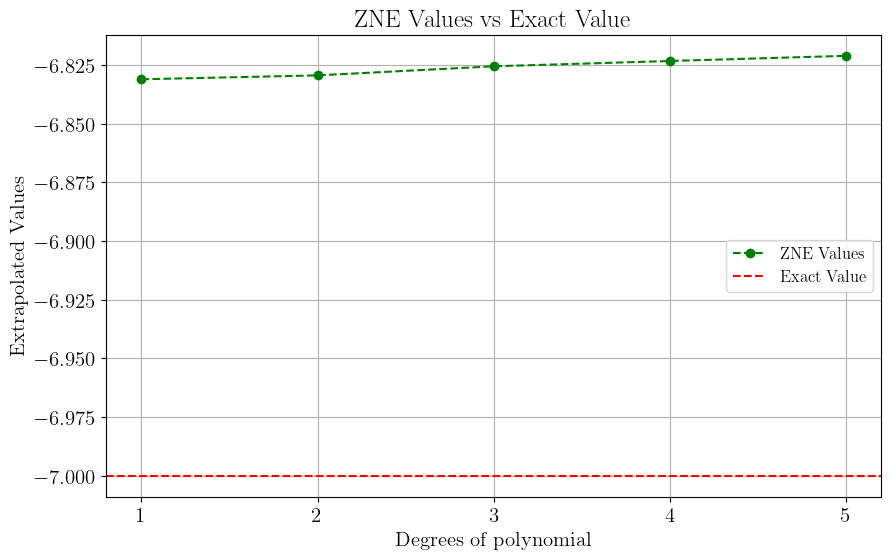

In [14]:
# List of zne values
zne_vals = [
    zne_8Q_1D_0_00001P_val,
    zne_8Q_2D_0_00001P_val,
    zne_8Q_3D_0_00001P_val,
    zne_8Q_4D_0_00001P_val,
    zne_8Q_5D_0_00001P_val
]

# Corresponding labels
labels = [
    '1',
    '2',
    '3',
    '4',
    '5'
]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(labels, zne_vals, marker='o', linestyle='--', color='green', label='ZNE Values')
plt.axhline(y=exact_val_8Q, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees of polynomial')
plt.ylabel('Extrapolated Values')
plt.title('ZNE Values vs Exact Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The following is the configuration for our indirect circuit.

```qubit = 8
layer = 25
noise probabilities = [0.0001, 0.0001, 0.0001, 0.0001]
exact solution = -7.000000000000004
```

We ran our indirect eigen solver at various noise level by changing the `factor` value inside the `config.yml`

In [22]:
data_sys1 = [
    (4, 1, 0, -6.742247461826676),
    (12, 3, 8, -6.405455124800368),
    (12, 5, 24, -5.839787462274414),
    (4, 7, 8, -5.991097523966149),
    (4, 7, 24, -5.533783365921837),
    (28, 9, 24, -5.005206166353052),
    (4, 9, 56, -4.206331147604706),
    (44, 1, 24, -6.357848309361182),
    (44, 3, 24, -5.9516342852267075),
    (4, 13, 8, -5.328222900577986)
]

zne_sys1 = ZeroNoiseExtrapolation(dataPoints= data_sys1, degree= 2)
zne_sys1.getRichardsonZNE()



-6.821098781914534

System #2

```qubit = 8
layer = 25
noise probabilities = [0.000001, 0.000001, 0.000001, 0.000001]
exact solution = -7.000000000000004
```


In [24]:
data_set2 = [
    (4, 1, 0, -6.254792723611204),
    (12, 3, 8, -6.250858745027363),
    (12, 5, 8, -6.2478883834002135),
    (4, 5, 24, -6.244810370105138),
    (20, 5, 24, -6.242889589082837),
    (4, 7, 24, -6.239825585489937),
    (12, 7, 40, -6.2328185853721925),
    (12, 1, 40, -6.253830617363461),
    (4, 11, 8, -6.23994604760344),
    (12, 11, 8, -6.238986354642458)
]

zne_set2 = ZeroNoiseExtrapolation(dataPoints = data_set2, degree = 2)
zne_set2.getRichardsonZNE()
-6.256252868096004

-6.256252868096004